# CHILDES Chinese: Age vs IPSyn Score

In [1]:
import os
import csv
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

In [2]:
# List of CSV files to process
ipsyn_files_50 = ['Kang_ipsyn50.csv', 'Laohu_ipsyn50.csv', 'Peng_ipsyn50.csv', 'Zhong_ipsyn50.csv', 'Cheng_ipsyn50.csv', 'Chou_ipsyn50.csv', 'Chw_ipsyn50.csv', 'Jc_ipsyn50.csv', 'Pan_ipsyn50.csv', 'Wang_ipsyn50.csv', 'Wu_ipsyn50.csv', 'Wuys_ipsyn50.csv', 'Xu_ipsyn50.csv', 'Yang_ipsyn50.csv', 'Tong_ipsyn50.csv', 'Zhou3_ipsyn50.csv']  # Uses _ipsyn50.csv files
ipsyn_files_100 = ['Kang_ipsyn100.csv', 'Laohu_ipsyn100.csv', 'Peng_ipsyn100.csv', 'Zhong_ipsyn100.csv', 'Cheng_ipsyn100.csv', 'Chou_ipsyn100.csv', 'Chw_ipsyn100.csv', 'Jc_ipsyn100.csv', 'Pan_ipsyn100.csv', 'Wang_ipsyn100.csv', 'Wu_ipsyn100.csv', 'Wuys_ipsyn100.csv', 'Xu_ipsyn100.csv', 'Yang_ipsyn100.csv', 'Tong_ipsyn100.csv', 'Zhou3_ipsyn100.csv']  # Uses _ipsyn100.csv files

# Initialize a 2D array to store Spearman's rho values for each CSV file
spearman_rhos_50 = []
spearman_rhos_100 = []

# Load the original _mlu.csv files to get ages (they are the only files that have the corresponding ages for each transcript)
age_files = ['Kang_mlu.csv', 'Laohu_mlu.csv', 'Peng_mlu.csv', 'Zhong_mlu.csv', 'Cheng_mlu.csv', 'Chou_mlu.csv', 'Chw_mlu.csv', 'Jc_mlu.csv', 'Pan_mlu.csv', 'Wang_mlu.csv', 'Wu_mlu.csv', 'Wuys_mlu.csv', 'Xu_mlu.csv', 'Yang_mlu.csv', 'Tong_mlu.csv', 'Zhou3_mlu.csv']

In [3]:
def age_in_months(age_str):
    parts = age_str.split(';')
    if len(parts) == 2:  # Example Format: "2;11.28", "2;05.", or "3;"
        years = int(parts[0])
        months_and_days = parts[1].split('.')
        
        # Handle cases where days are not provided
        if months_and_days[0] == '':
            months = 0  # Assume 00 months if no months are provided
        else:
            months = float(months_and_days[0])
        
        # Check if the month format ends with a dot, indicating missing days
        if len(months_and_days) > 1 and months_and_days[1] == '':
            days = 0  # Assume 00 days if no days are provided
        else:
            days = float(months_and_days[1]) if len(months_and_days) > 1 else 0
        
        months += days / 30  # Keep decimal for days
        return years * 12 + months
    return 0  # Consider raising an error instead of returning 0 for invalid formats

In [4]:
def age_ipsyn_plots(ipsyn_files, spearman_rhos, age_files):
    age_data = {}

    for age_file in age_files:
        if os.path.exists(age_file):
            with open(age_file, 'r', encoding='utf-8') as file:
                reader = csv.DictReader(file)
                data = list(reader)
                # Store ages in a dictionary with the base filename as the key
                for entry in data:
                    base_filename = entry['File'].split('.')[0]  # Get the base filename
                    age_data[base_filename] = age_in_months(entry['Age'])  # Store the age

    for ipsyn_file in ipsyn_files:
        # Check if the file exists before attempting to open it
        if os.path.exists(ipsyn_file):
            with open(ipsyn_file, 'r', encoding='utf-8') as file:
                reader = csv.DictReader(file)
                data = list(reader)

            # Initialize list to hold chosen transcripts and their IPSyn scores
            chosen_transcripts = []
            transcript_list = []
            time_steps = []  # New list to hold time steps

            # Select the first transcript
            if data:  # Check if there is any data
                first_data = data[0]
                # Extract the base filename to get the corresponding age
                base_filename = first_data['File'].split('.')[0]
                first_age = age_data.get(base_filename, 0)  # Get the corresponding age or default to 0
                chosen_transcripts.append((first_age, float(first_data['IPSyn Score'])))
                transcript_list.append(first_data['File'])  # Collect the first transcript name

                last_chosen_age = first_age

                # Select subsequent transcripts that are at least 1 month apart
                for entry in data[1:]:  # Start from the second transcript
                    base_filename = entry['File'].split('.')[0]
                    current_age = age_data.get(base_filename, 0)  # Get the corresponding age or default to 0
                    if current_age - last_chosen_age >= 1:
                        chosen_transcripts.append((current_age, float(entry['IPSyn Score'])))  # Collect age and IPSyn score
                        transcript_list.append(entry['File'])  # Collect the transcript name
                        time_steps.append(current_age - last_chosen_age)  # Calculate time step without rounding
                        last_chosen_age = current_age

            # Plot Age vs IPSyn Score
            ages = [t[0] for t in chosen_transcripts]
            ipsyn_scores = [t[1] for t in chosen_transcripts]

            plt.figure(figsize=(10, 5))
            plt.scatter(ages, ipsyn_scores, marker='o')  # scatter plot
            plt.title(f'Age vs IPSyn Score for {ipsyn_file}')
            plt.xlabel('Age (months)')
            plt.ylabel('IPSyn Score')
            plt.grid()
            plt.show()       

            # Calculate Spearman's rho
            if len(ages) > 1:  # Ensure there are enough data points
                spearman_corr, _ = spearmanr(ages, ipsyn_scores)
                spearman_rhos.append([ipsyn_file, spearman_corr])  # Store the file name and Spearman's rho value
                print(f"Spearman's rho for {ipsyn_file}: {spearman_corr:.4f}\n")

            # Print the list of chosen transcripts, converted ages, and time steps
            print(f"Chosen Transcripts for {ipsyn_file}: \n", transcript_list, "\n")
            print(f"IPSyn Scores for {ipsyn_file}: \n", ipsyn_scores, "\n")  # Print the IPSyn scores
            print(f"Ages for {ipsyn_file}: \n", ages, "\n")  # Print the converted ages
            print(f"Time Steps for {ipsyn_file}: \n", time_steps, "\n")  # Print the time steps

## Age vs IPSyn Score (50 Utterances)

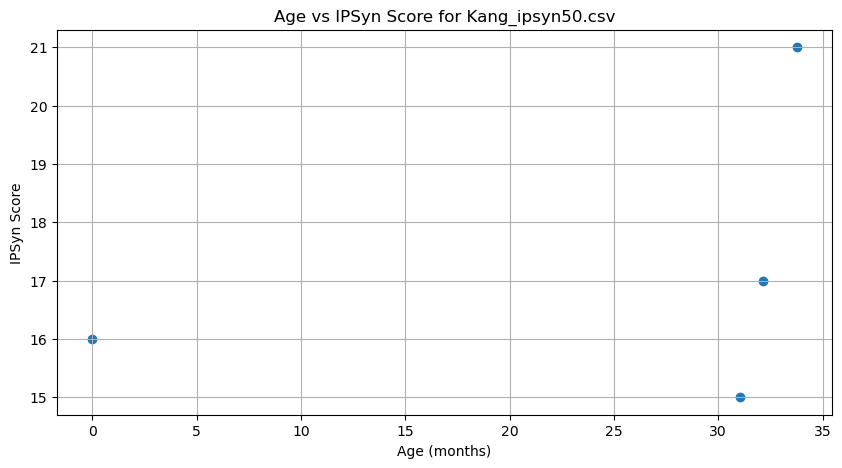

Spearman's rho for Kang_ipsyn50.csv: 0.8000

Chosen Transcripts for Kang_ipsyn50.csv: 
 ['01.cha', '02.cha', '19.cha', '21.cha'] 

IPSyn Scores for Kang_ipsyn50.csv: 
 [16.0, 15.0, 17.0, 21.0] 

Ages for Kang_ipsyn50.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666] 

Time Steps for Kang_ipsyn50.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329] 



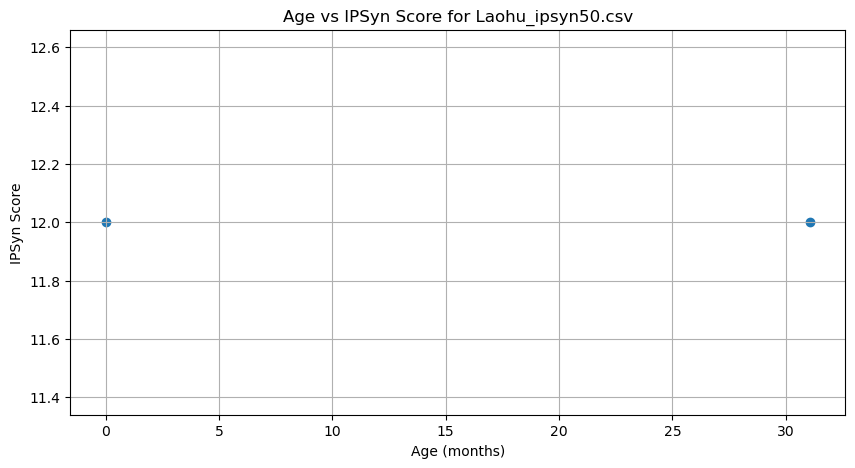

Spearman's rho for Laohu_ipsyn50.csv: nan

Chosen Transcripts for Laohu_ipsyn50.csv: 
 ['01.cha', '02.cha'] 

IPSyn Scores for Laohu_ipsyn50.csv: 
 [12.0, 12.0] 

Ages for Laohu_ipsyn50.csv: 
 [0, 31.066666666666666] 

Time Steps for Laohu_ipsyn50.csv: 
 [31.066666666666666] 



c:\Users\a_deb\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:5445: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(warn_msg))


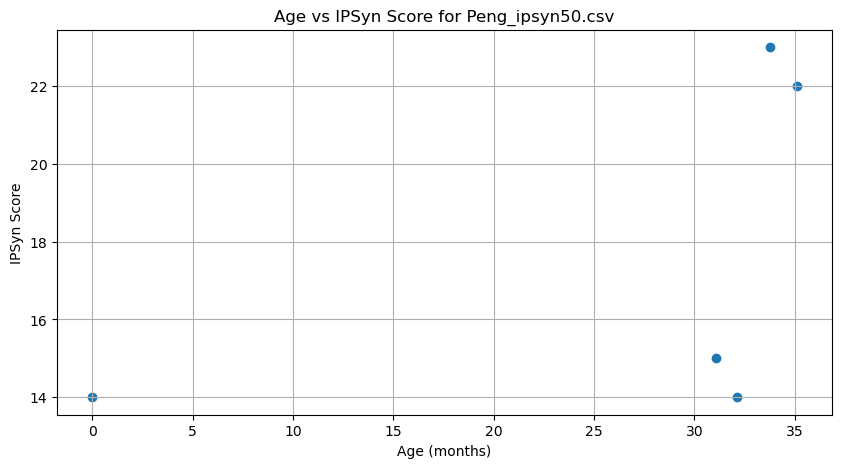

Spearman's rho for Peng_ipsyn50.csv: 0.7182

Chosen Transcripts for Peng_ipsyn50.csv: 
 ['01.cha', '02.cha', '19.cha', '21.cha', '24.cha'] 

IPSyn Scores for Peng_ipsyn50.csv: 
 [14.0, 15.0, 14.0, 23.0, 22.0] 

Ages for Peng_ipsyn50.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666, 35.1] 

Time Steps for Peng_ipsyn50.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329, 1.3333333333333357] 



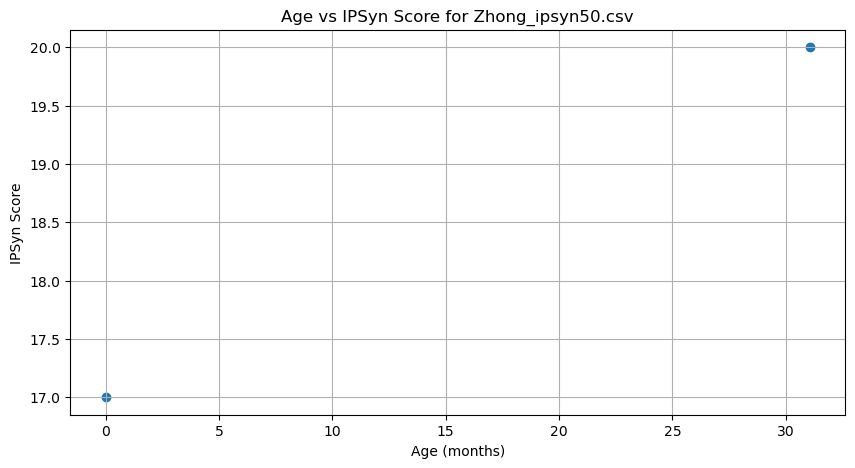

Spearman's rho for Zhong_ipsyn50.csv: 1.0000

Chosen Transcripts for Zhong_ipsyn50.csv: 
 ['01.cha', '02.cha'] 

IPSyn Scores for Zhong_ipsyn50.csv: 
 [17.0, 20.0] 

Ages for Zhong_ipsyn50.csv: 
 [0, 31.066666666666666] 

Time Steps for Zhong_ipsyn50.csv: 
 [31.066666666666666] 



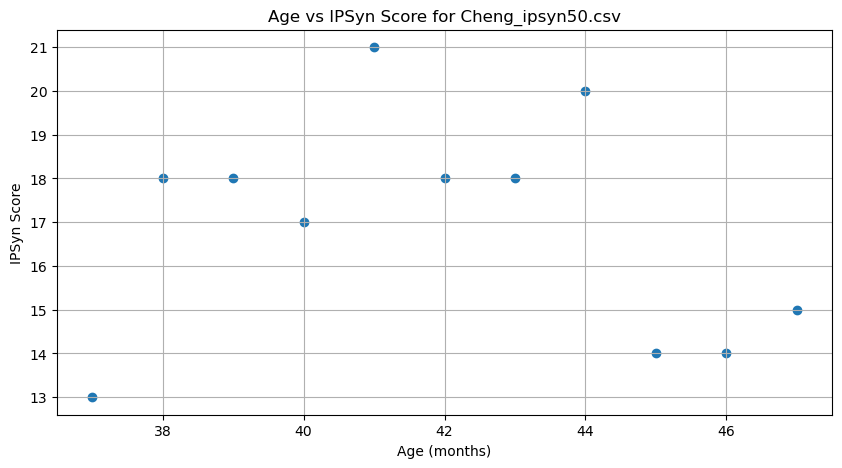

Spearman's rho for Cheng_ipsyn50.csv: -0.1259

Chosen Transcripts for Cheng_ipsyn50.csv: 
 ['030100.cha', '030200.cha', '030300.cha', '030400.cha', '030500.cha', '030600.cha', '030700.cha', '030800.cha', '030900.cha', '031000.cha', '031100.cha'] 

IPSyn Scores for Cheng_ipsyn50.csv: 
 [13.0, 18.0, 18.0, 17.0, 21.0, 18.0, 18.0, 20.0, 14.0, 14.0, 15.0] 

Ages for Cheng_ipsyn50.csv: 
 [37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0] 

Time Steps for Cheng_ipsyn50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



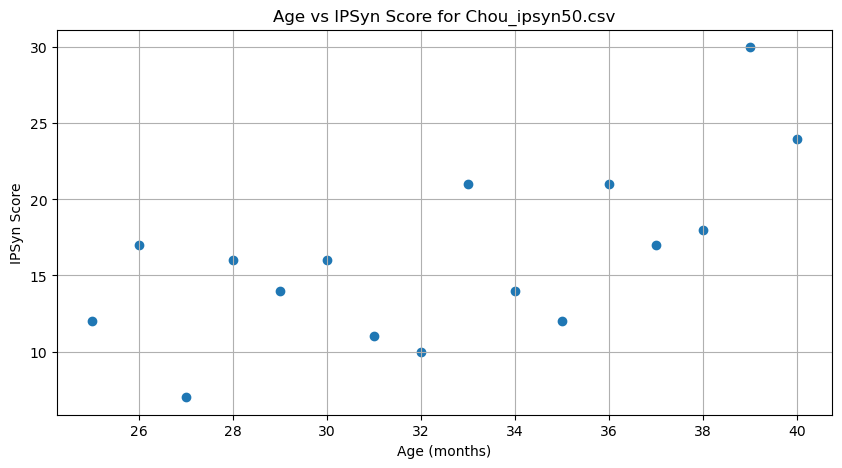

Spearman's rho for Chou_ipsyn50.csv: 0.6185

Chosen Transcripts for Chou_ipsyn50.csv: 
 ['020100.cha', '020200.cha', '020300.cha', '020400.cha', '020500.cha', '020600.cha', '020700.cha', '020800.cha', '020900.cha', '021000.cha', '021100.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030400.cha'] 

IPSyn Scores for Chou_ipsyn50.csv: 
 [12.0, 17.0, 7.0, 16.0, 14.0, 16.0, 11.0, 10.0, 21.0, 14.0, 12.0, 21.0, 17.0, 18.0, 30.0, 24.0] 

Ages for Chou_ipsyn50.csv: 
 [25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Chou_ipsyn50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



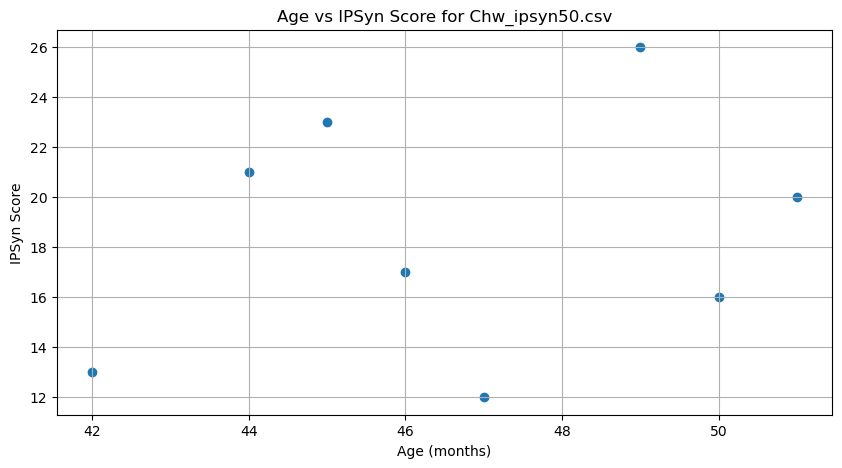

Spearman's rho for Chw_ipsyn50.csv: 0.0714

Chosen Transcripts for Chw_ipsyn50.csv: 
 ['030600.cha', '030800.cha', '030900.cha', '031000.cha', '031100.cha', '040100.cha', '040200.cha', '040300.cha'] 

IPSyn Scores for Chw_ipsyn50.csv: 
 [13.0, 21.0, 23.0, 17.0, 12.0, 26.0, 16.0, 20.0] 

Ages for Chw_ipsyn50.csv: 
 [42.0, 44.0, 45.0, 46.0, 47.0, 49.0, 50.0, 51.0] 

Time Steps for Chw_ipsyn50.csv: 
 [2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0] 



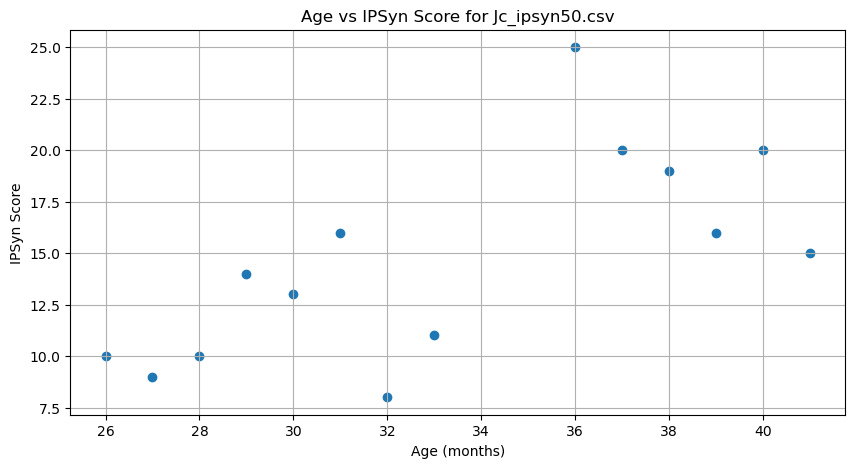

Spearman's rho for Jc_ipsyn50.csv: 0.6748

Chosen Transcripts for Jc_ipsyn50.csv: 
 ['020200.cha', '020300.cha', '020400.cha', '020500.cha', '020600.cha', '020700.cha', '020800.cha', '020900.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030400.cha', '030500.cha'] 

IPSyn Scores for Jc_ipsyn50.csv: 
 [10.0, 9.0, 10.0, 14.0, 13.0, 16.0, 8.0, 11.0, 25.0, 20.0, 19.0, 16.0, 20.0, 15.0] 

Ages for Jc_ipsyn50.csv: 
 [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 36.0, 37.0, 38.0, 39.0, 40.0, 41.0] 

Time Steps for Jc_ipsyn50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



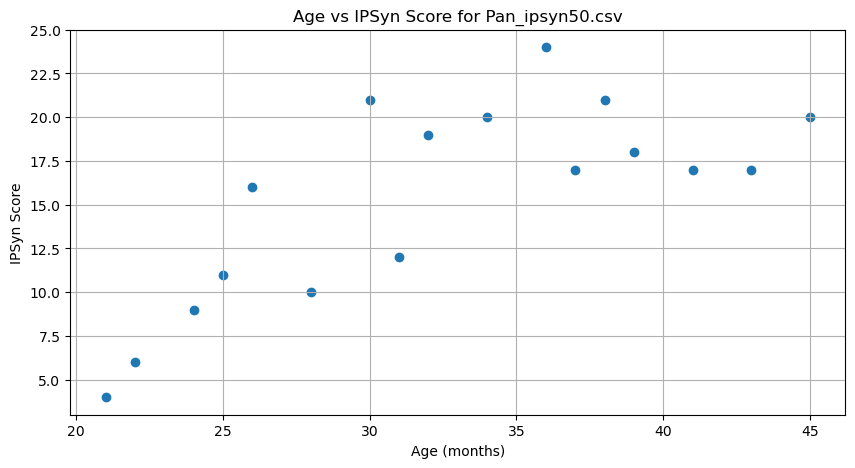

Spearman's rho for Pan_ipsyn50.csv: 0.6753

Chosen Transcripts for Pan_ipsyn50.csv: 
 ['010900.cha', '011000.cha', '020000.cha', '020100.cha', '020200.cha', '020400.cha', '020600.cha', '020700.cha', '020800.cha', '021000.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030500.cha', '030700.cha', '030900.cha'] 

IPSyn Scores for Pan_ipsyn50.csv: 
 [4.0, 6.0, 9.0, 11.0, 16.0, 10.0, 21.0, 12.0, 19.0, 20.0, 24.0, 17.0, 21.0, 18.0, 17.0, 17.0, 20.0] 

Ages for Pan_ipsyn50.csv: 
 [21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, 31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 41.0, 43.0, 45.0] 

Time Steps for Pan_ipsyn50.csv: 
 [1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0] 



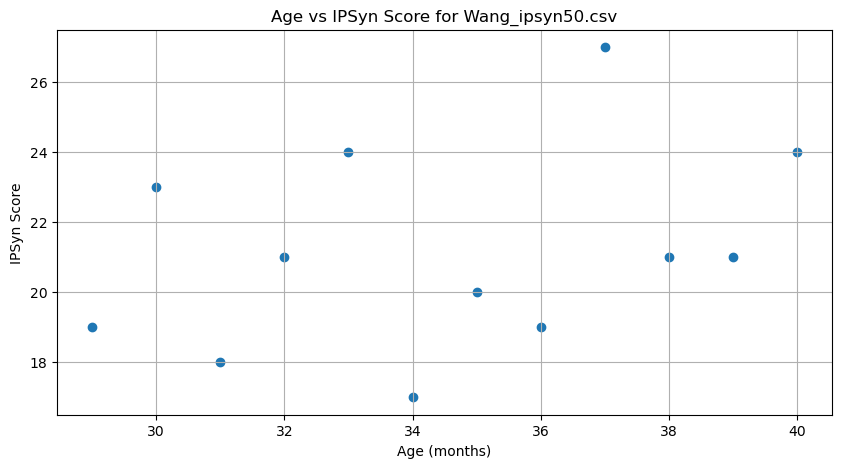

Spearman's rho for Wang_ipsyn50.csv: 0.3604

Chosen Transcripts for Wang_ipsyn50.csv: 
 ['020500.cha', '020600.cha', '020700.cha', '020800.cha', '020900.cha', '021000.cha', '021100.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030400.cha'] 

IPSyn Scores for Wang_ipsyn50.csv: 
 [19.0, 23.0, 18.0, 21.0, 24.0, 17.0, 20.0, 19.0, 27.0, 21.0, 21.0, 24.0] 

Ages for Wang_ipsyn50.csv: 
 [29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Wang_ipsyn50.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



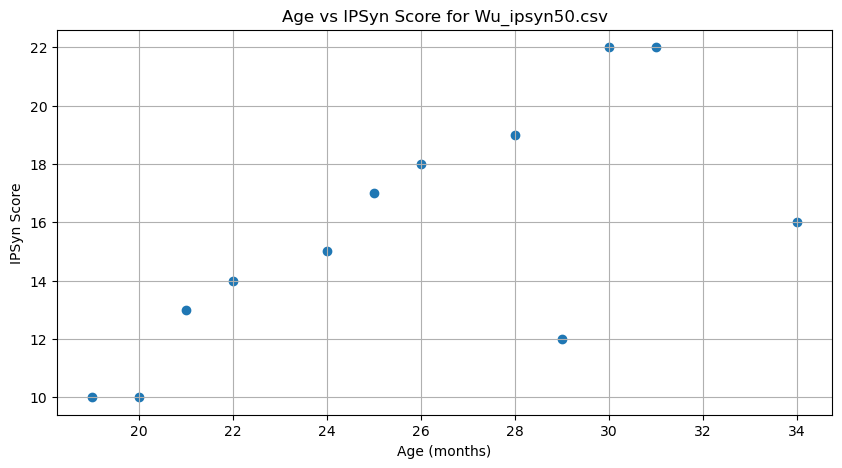

Spearman's rho for Wu_ipsyn50.csv: 0.7228

Chosen Transcripts for Wu_ipsyn50.csv: 
 ['010700.cha', '010800.cha', '010900.cha', '011000.cha', '020000.cha', '020100.cha', '020200.cha', '020400.cha', '020500.cha', '020600.cha', '020700.cha', '021000.cha'] 

IPSyn Scores for Wu_ipsyn50.csv: 
 [10.0, 10.0, 13.0, 14.0, 15.0, 17.0, 18.0, 19.0, 12.0, 22.0, 22.0, 16.0] 

Ages for Wu_ipsyn50.csv: 
 [19.0, 20.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 29.0, 30.0, 31.0, 34.0] 

Time Steps for Wu_ipsyn50.csv: 
 [1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0] 



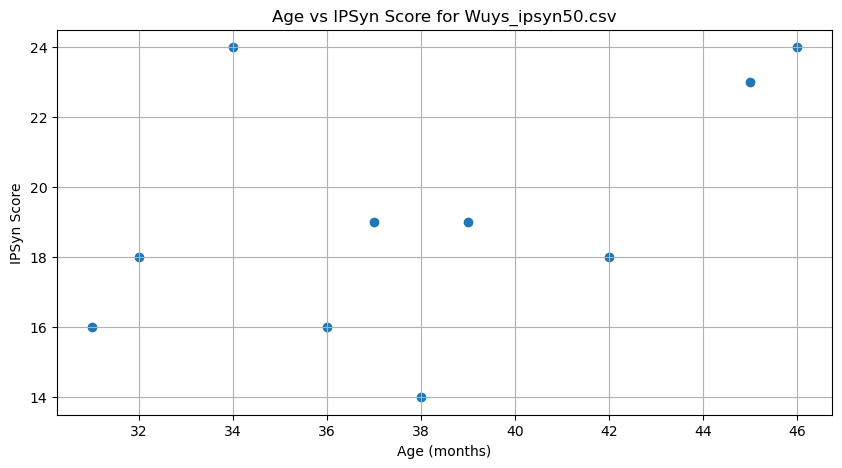

Spearman's rho for Wuys_ipsyn50.csv: 0.4233

Chosen Transcripts for Wuys_ipsyn50.csv: 
 ['020700.cha', '020800.cha', '021000.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030600.cha', '030900.cha', '031000.cha'] 

IPSyn Scores for Wuys_ipsyn50.csv: 
 [16.0, 18.0, 24.0, 16.0, 19.0, 14.0, 19.0, 18.0, 23.0, 24.0] 

Ages for Wuys_ipsyn50.csv: 
 [31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 42.0, 45.0, 46.0] 

Time Steps for Wuys_ipsyn50.csv: 
 [1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0] 



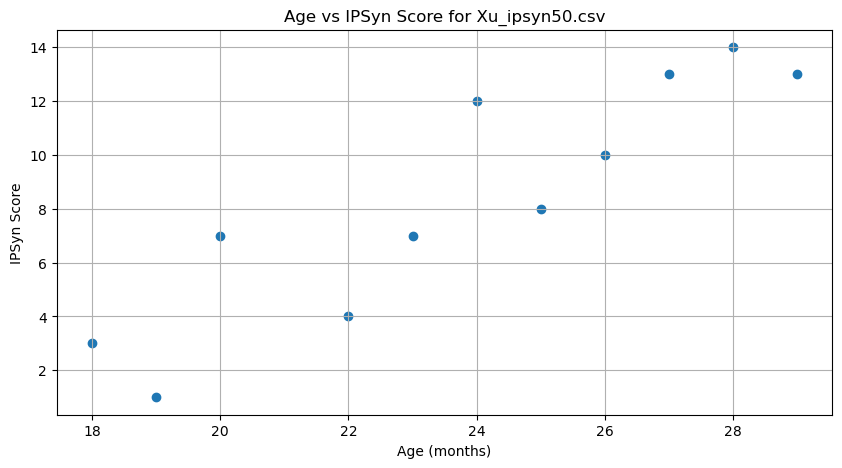

Spearman's rho for Xu_ipsyn50.csv: 0.9315

Chosen Transcripts for Xu_ipsyn50.csv: 
 ['010600.cha', '010700.cha', '010800.cha', '011000.cha', '011100.cha', '020000.cha', '020100.cha', '020200.cha', '020300.cha', '020400.cha', '020500.cha'] 

IPSyn Scores for Xu_ipsyn50.csv: 
 [3.0, 1.0, 7.0, 4.0, 7.0, 12.0, 8.0, 10.0, 13.0, 14.0, 13.0] 

Ages for Xu_ipsyn50.csv: 
 [18.0, 19.0, 20.0, 22.0, 23.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0] 

Time Steps for Xu_ipsyn50.csv: 
 [1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



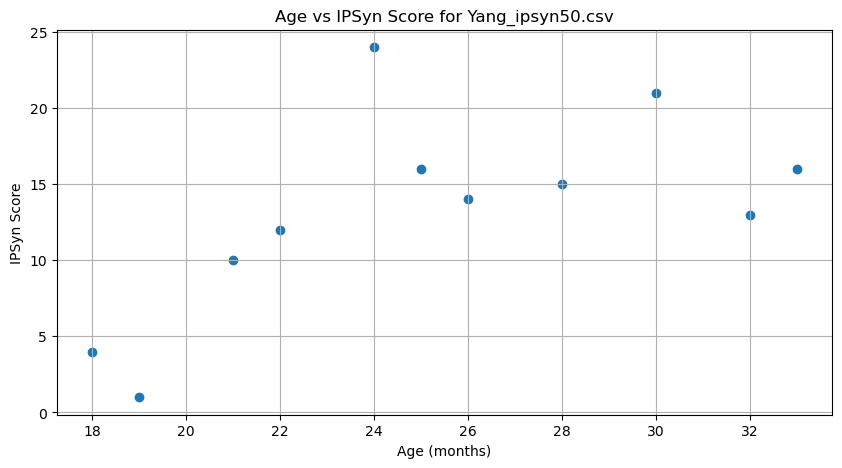

Spearman's rho for Yang_ipsyn50.csv: 0.6424

Chosen Transcripts for Yang_ipsyn50.csv: 
 ['010600.cha', '010700.cha', '010900.cha', '011000.cha', '020000.cha', '020100.cha', '020200.cha', '020400.cha', '020600.cha', '020800.cha', '020900.cha'] 

IPSyn Scores for Yang_ipsyn50.csv: 
 [4.0, 1.0, 10.0, 12.0, 24.0, 16.0, 14.0, 15.0, 21.0, 13.0, 16.0] 

Ages for Yang_ipsyn50.csv: 
 [18.0, 19.0, 21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 30.0, 32.0, 33.0] 

Time Steps for Yang_ipsyn50.csv: 
 [1.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0] 



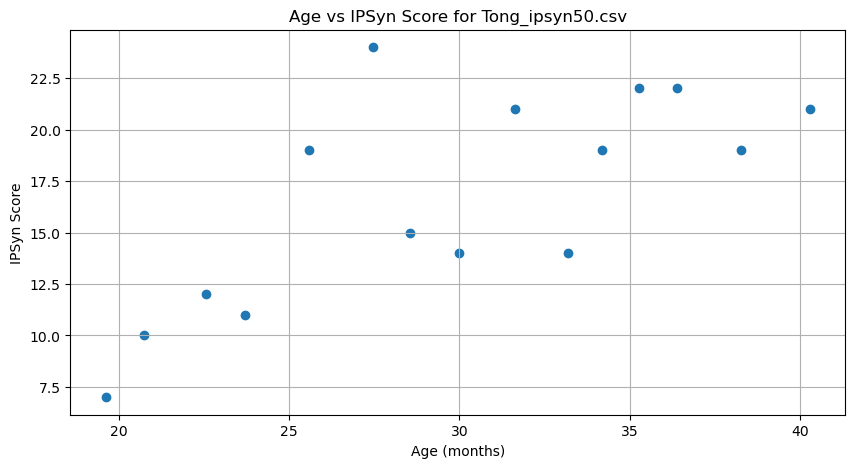

Spearman's rho for Tong_ipsyn50.csv: 0.6846

Chosen Transcripts for Tong_ipsyn50.csv: 
 ['010718.cha', '010822.cha', '011017.cha', '011121.cha', '020117.cha', '020314.cha', '020416.cha', '020530.cha', '020719.cha', '020906.cha', '021006.cha', '021108.cha', '030012.cha', '030208.cha', '030409.cha'] 

IPSyn Scores for Tong_ipsyn50.csv: 
 [7.0, 10.0, 12.0, 11.0, 19.0, 24.0, 15.0, 14.0, 21.0, 14.0, 19.0, 22.0, 22.0, 19.0, 21.0] 

Ages for Tong_ipsyn50.csv: 
 [19.6, 20.733333333333334, 22.566666666666666, 23.7, 25.566666666666666, 27.46666666666667, 28.53333333333333, 30.0, 31.633333333333333, 33.2, 34.2, 35.266666666666666, 36.4, 38.266666666666666, 40.3] 

Time Steps for Tong_ipsyn50.csv: 
 [1.1333333333333329, 1.8333333333333321, 1.1333333333333329, 1.8666666666666671, 1.9000000000000021, 1.0666666666666629, 1.4666666666666686, 1.6333333333333329, 1.56666666666667, 1.0, 1.0666666666666629, 1.1333333333333329, 1.8666666666666671, 2.0333333333333314] 



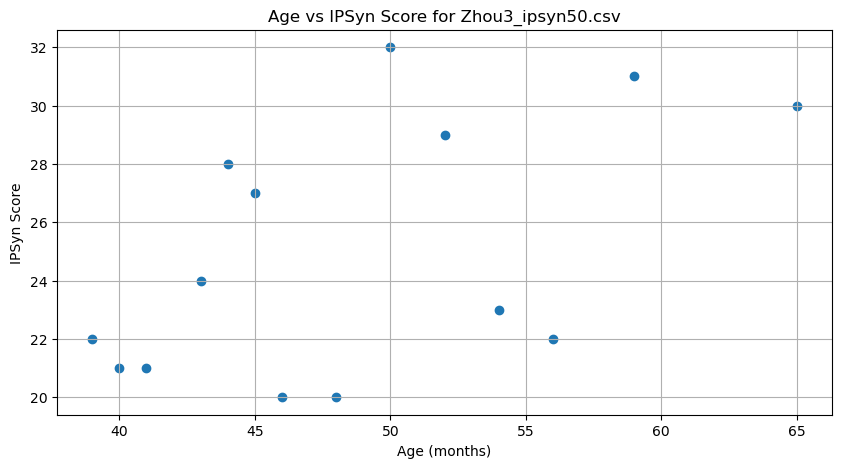

Spearman's rho for Zhou3_ipsyn50.csv: 0.4851

Chosen Transcripts for Zhou3_ipsyn50.csv: 
 ['000108.cha', '000227.cha', '000326.cha', '000506.cha', '000610.cha', '000702.cha', '000822.cha', '001005.cha', '001209.cha', '010218.cha', '010421.cha', '010630.cha', '010908.cha', '020323.cha'] 

IPSyn Scores for Zhou3_ipsyn50.csv: 
 [22.0, 21.0, 21.0, 24.0, 28.0, 27.0, 20.0, 20.0, 32.0, 29.0, 23.0, 22.0, 31.0, 30.0] 

Ages for Zhou3_ipsyn50.csv: 
 [39.0, 40.0, 41.0, 43.0, 44.0, 45.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 59.0, 65.0] 

Time Steps for Zhou3_ipsyn50.csv: 
 [1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 6.0] 



In [5]:
age_ipsyn_plots(ipsyn_files_50, spearman_rhos_50, age_files)

## Age vs IPSyn Score (100 Utterances)

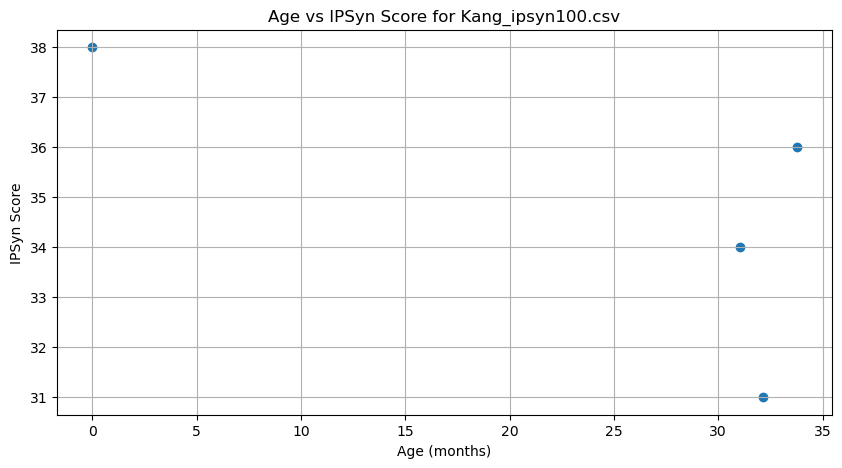

Spearman's rho for Kang_ipsyn100.csv: -0.4000

Chosen Transcripts for Kang_ipsyn100.csv: 
 ['01.cha', '02.cha', '19.cha', '21.cha'] 

IPSyn Scores for Kang_ipsyn100.csv: 
 [38.0, 34.0, 31.0, 36.0] 

Ages for Kang_ipsyn100.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666] 

Time Steps for Kang_ipsyn100.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329] 



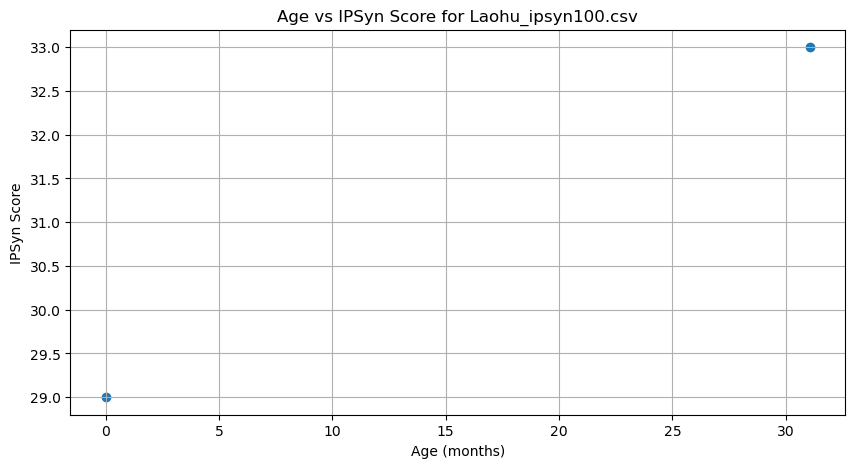

Spearman's rho for Laohu_ipsyn100.csv: 1.0000

Chosen Transcripts for Laohu_ipsyn100.csv: 
 ['01.cha', '02.cha'] 

IPSyn Scores for Laohu_ipsyn100.csv: 
 [29.0, 33.0] 

Ages for Laohu_ipsyn100.csv: 
 [0, 31.066666666666666] 

Time Steps for Laohu_ipsyn100.csv: 
 [31.066666666666666] 



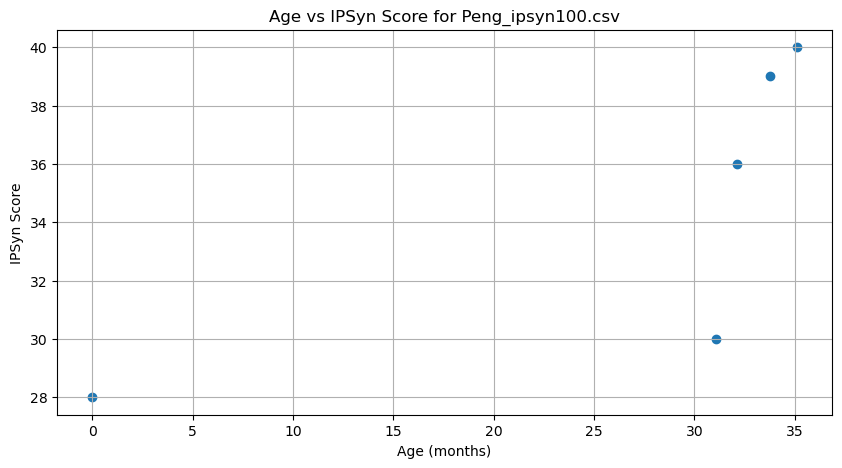

Spearman's rho for Peng_ipsyn100.csv: 1.0000

Chosen Transcripts for Peng_ipsyn100.csv: 
 ['01.cha', '02.cha', '19.cha', '21.cha', '24.cha'] 

IPSyn Scores for Peng_ipsyn100.csv: 
 [28.0, 30.0, 36.0, 39.0, 40.0] 

Ages for Peng_ipsyn100.csv: 
 [0, 31.066666666666666, 32.13333333333333, 33.766666666666666, 35.1] 

Time Steps for Peng_ipsyn100.csv: 
 [31.066666666666666, 1.0666666666666664, 1.6333333333333329, 1.3333333333333357] 



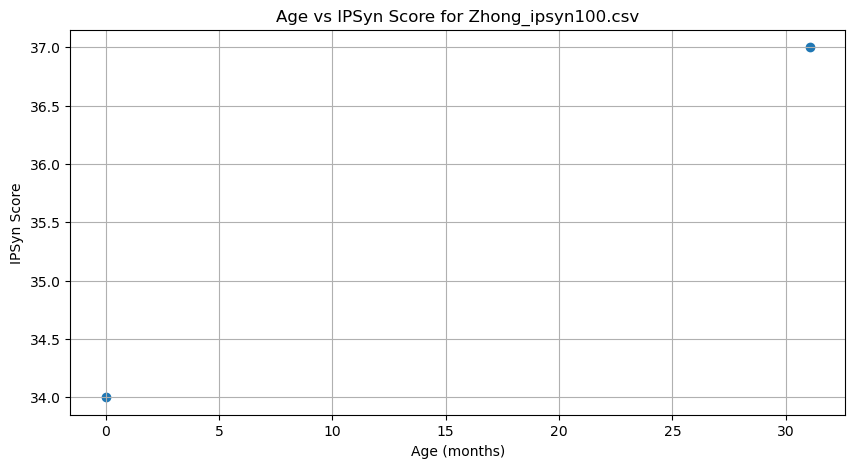

Spearman's rho for Zhong_ipsyn100.csv: 1.0000

Chosen Transcripts for Zhong_ipsyn100.csv: 
 ['01.cha', '02.cha'] 

IPSyn Scores for Zhong_ipsyn100.csv: 
 [34.0, 37.0] 

Ages for Zhong_ipsyn100.csv: 
 [0, 31.066666666666666] 

Time Steps for Zhong_ipsyn100.csv: 
 [31.066666666666666] 



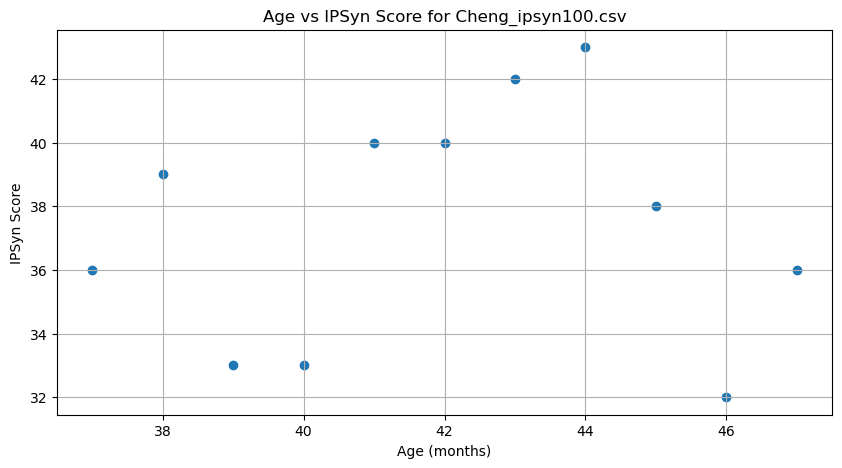

Spearman's rho for Cheng_ipsyn100.csv: 0.0458

Chosen Transcripts for Cheng_ipsyn100.csv: 
 ['030100.cha', '030200.cha', '030300.cha', '030400.cha', '030500.cha', '030600.cha', '030700.cha', '030800.cha', '030900.cha', '031000.cha', '031100.cha'] 

IPSyn Scores for Cheng_ipsyn100.csv: 
 [36.0, 39.0, 33.0, 33.0, 40.0, 40.0, 42.0, 43.0, 38.0, 32.0, 36.0] 

Ages for Cheng_ipsyn100.csv: 
 [37.0, 38.0, 39.0, 40.0, 41.0, 42.0, 43.0, 44.0, 45.0, 46.0, 47.0] 

Time Steps for Cheng_ipsyn100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



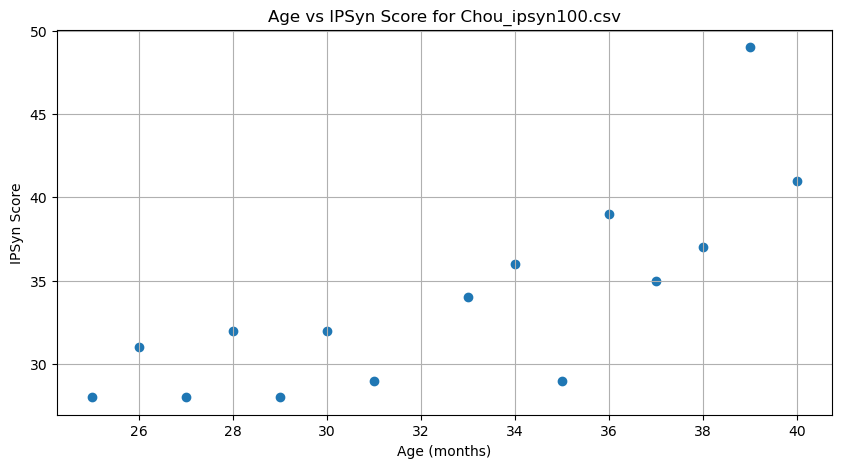

Spearman's rho for Chou_ipsyn100.csv: 0.8313

Chosen Transcripts for Chou_ipsyn100.csv: 
 ['020100.cha', '020200.cha', '020300.cha', '020400.cha', '020500.cha', '020600.cha', '020700.cha', '020900.cha', '021000.cha', '021100.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030400.cha'] 

IPSyn Scores for Chou_ipsyn100.csv: 
 [28.0, 31.0, 28.0, 32.0, 28.0, 32.0, 29.0, 34.0, 36.0, 29.0, 39.0, 35.0, 37.0, 49.0, 41.0] 

Ages for Chou_ipsyn100.csv: 
 [25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Chou_ipsyn100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



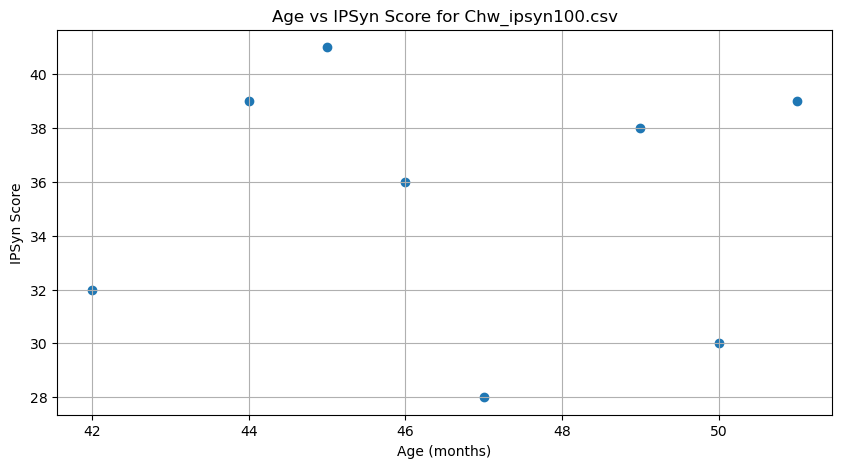

Spearman's rho for Chw_ipsyn100.csv: -0.1198

Chosen Transcripts for Chw_ipsyn100.csv: 
 ['030600.cha', '030800.cha', '030900.cha', '031000.cha', '031100.cha', '040100.cha', '040200.cha', '040300.cha'] 

IPSyn Scores for Chw_ipsyn100.csv: 
 [32.0, 39.0, 41.0, 36.0, 28.0, 38.0, 30.0, 39.0] 

Ages for Chw_ipsyn100.csv: 
 [42.0, 44.0, 45.0, 46.0, 47.0, 49.0, 50.0, 51.0] 

Time Steps for Chw_ipsyn100.csv: 
 [2.0, 1.0, 1.0, 1.0, 2.0, 1.0, 1.0] 



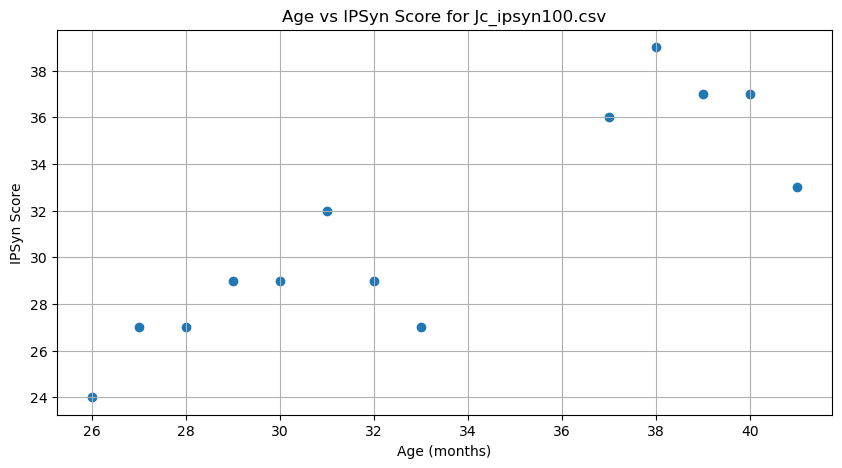

Spearman's rho for Jc_ipsyn100.csv: 0.8262

Chosen Transcripts for Jc_ipsyn100.csv: 
 ['020200.cha', '020300.cha', '020400.cha', '020500.cha', '020600.cha', '020700.cha', '020800.cha', '020900.cha', '030100.cha', '030200.cha', '030300.cha', '030400.cha', '030500.cha'] 

IPSyn Scores for Jc_ipsyn100.csv: 
 [24.0, 27.0, 27.0, 29.0, 29.0, 32.0, 29.0, 27.0, 36.0, 39.0, 37.0, 37.0, 33.0] 

Ages for Jc_ipsyn100.csv: 
 [26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 37.0, 38.0, 39.0, 40.0, 41.0] 

Time Steps for Jc_ipsyn100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 4.0, 1.0, 1.0, 1.0, 1.0] 



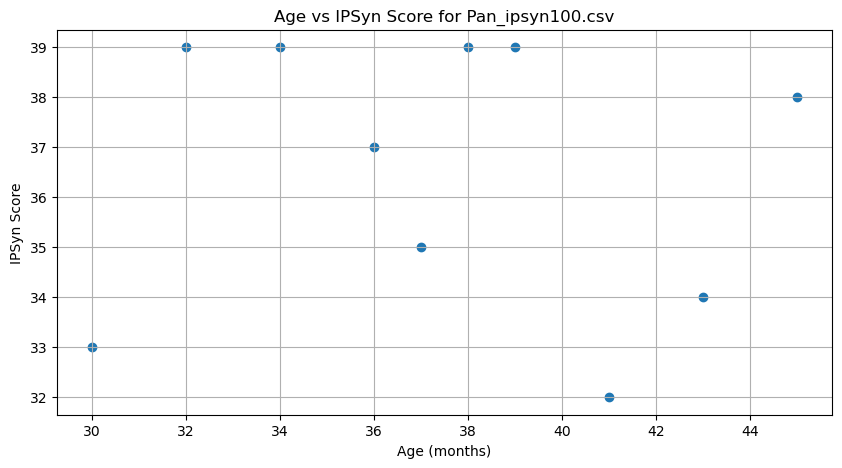

Spearman's rho for Pan_ipsyn100.csv: -0.1563

Chosen Transcripts for Pan_ipsyn100.csv: 
 ['020600.cha', '020800.cha', '021000.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030500.cha', '030700.cha', '030900.cha'] 

IPSyn Scores for Pan_ipsyn100.csv: 
 [33.0, 39.0, 39.0, 37.0, 35.0, 39.0, 39.0, 32.0, 34.0, 38.0] 

Ages for Pan_ipsyn100.csv: 
 [30.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 41.0, 43.0, 45.0] 

Time Steps for Pan_ipsyn100.csv: 
 [2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0] 



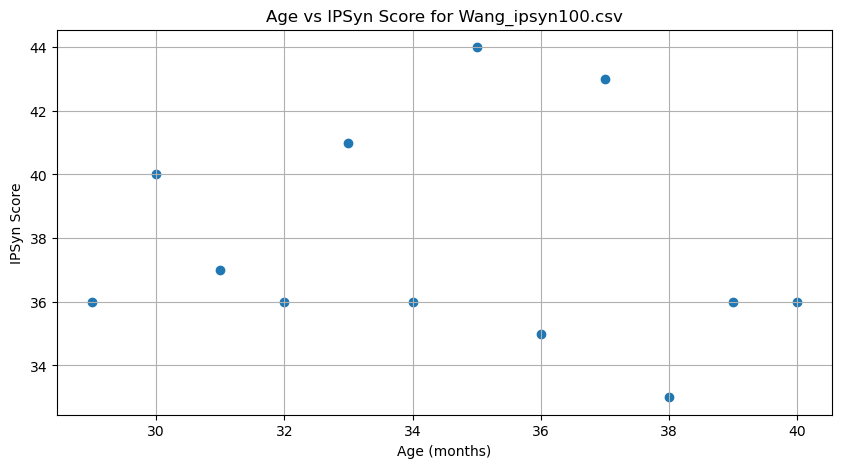

Spearman's rho for Wang_ipsyn100.csv: -0.2610

Chosen Transcripts for Wang_ipsyn100.csv: 
 ['020500.cha', '020600.cha', '020700.cha', '020800.cha', '020900.cha', '021000.cha', '021100.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030400.cha'] 

IPSyn Scores for Wang_ipsyn100.csv: 
 [36.0, 40.0, 37.0, 36.0, 41.0, 36.0, 44.0, 35.0, 43.0, 33.0, 36.0, 36.0] 

Ages for Wang_ipsyn100.csv: 
 [29.0, 30.0, 31.0, 32.0, 33.0, 34.0, 35.0, 36.0, 37.0, 38.0, 39.0, 40.0] 

Time Steps for Wang_ipsyn100.csv: 
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



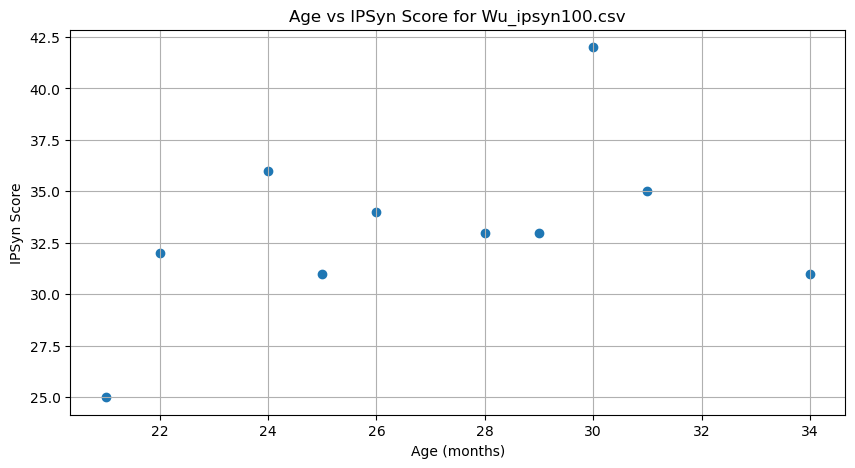

Spearman's rho for Wu_ipsyn100.csv: 0.3293

Chosen Transcripts for Wu_ipsyn100.csv: 
 ['010900.cha', '011000.cha', '020000.cha', '020100.cha', '020200.cha', '020400.cha', '020500.cha', '020600.cha', '020700.cha', '021000.cha'] 

IPSyn Scores for Wu_ipsyn100.csv: 
 [25.0, 32.0, 36.0, 31.0, 34.0, 33.0, 33.0, 42.0, 35.0, 31.0] 

Ages for Wu_ipsyn100.csv: 
 [21.0, 22.0, 24.0, 25.0, 26.0, 28.0, 29.0, 30.0, 31.0, 34.0] 

Time Steps for Wu_ipsyn100.csv: 
 [1.0, 2.0, 1.0, 1.0, 2.0, 1.0, 1.0, 1.0, 3.0] 



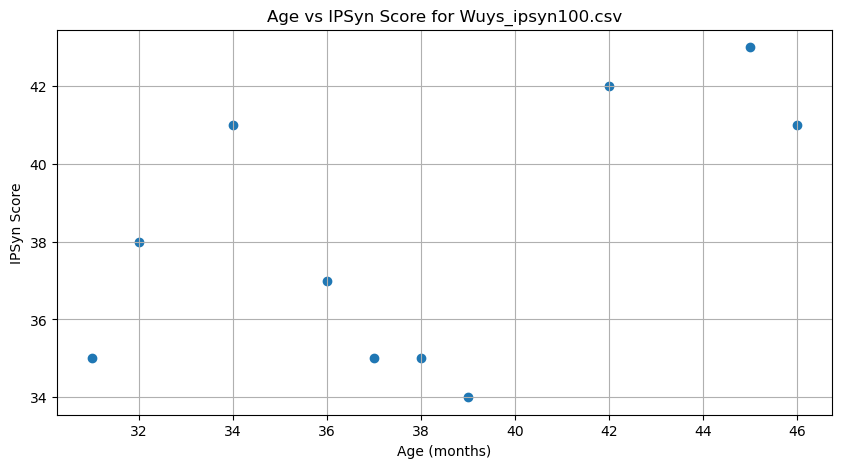

Spearman's rho for Wuys_ipsyn100.csv: 0.3939

Chosen Transcripts for Wuys_ipsyn100.csv: 
 ['020700.cha', '020800.cha', '021000.cha', '030000.cha', '030100.cha', '030200.cha', '030300.cha', '030600.cha', '030900.cha', '031000.cha'] 

IPSyn Scores for Wuys_ipsyn100.csv: 
 [35.0, 38.0, 41.0, 37.0, 35.0, 35.0, 34.0, 42.0, 43.0, 41.0] 

Ages for Wuys_ipsyn100.csv: 
 [31.0, 32.0, 34.0, 36.0, 37.0, 38.0, 39.0, 42.0, 45.0, 46.0] 

Time Steps for Wuys_ipsyn100.csv: 
 [1.0, 2.0, 2.0, 1.0, 1.0, 1.0, 3.0, 3.0, 1.0] 



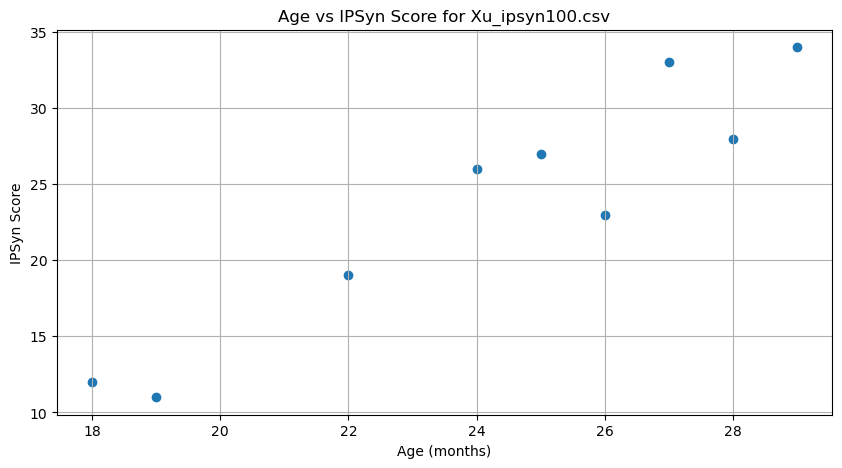

Spearman's rho for Xu_ipsyn100.csv: 0.9167

Chosen Transcripts for Xu_ipsyn100.csv: 
 ['010600.cha', '010700.cha', '011000.cha', '020000.cha', '020100.cha', '020200.cha', '020300.cha', '020400.cha', '020500.cha'] 

IPSyn Scores for Xu_ipsyn100.csv: 
 [12.0, 11.0, 19.0, 26.0, 27.0, 23.0, 33.0, 28.0, 34.0] 

Ages for Xu_ipsyn100.csv: 
 [18.0, 19.0, 22.0, 24.0, 25.0, 26.0, 27.0, 28.0, 29.0] 

Time Steps for Xu_ipsyn100.csv: 
 [1.0, 3.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0] 



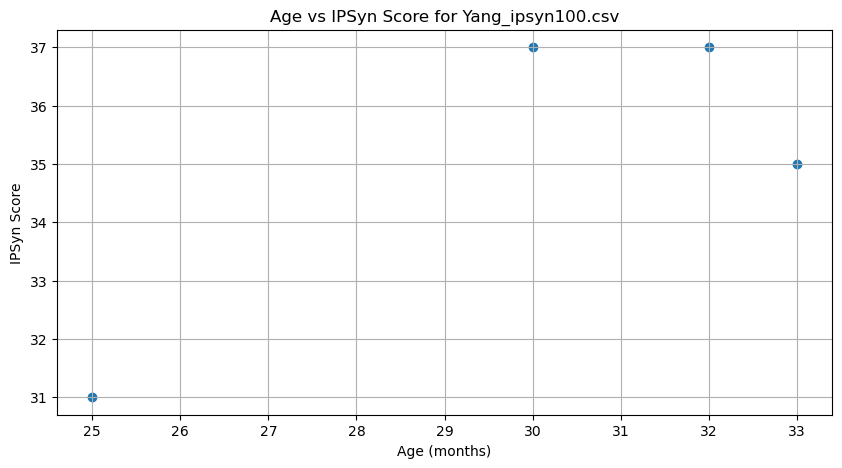

Spearman's rho for Yang_ipsyn100.csv: 0.3162

Chosen Transcripts for Yang_ipsyn100.csv: 
 ['020100.cha', '020600.cha', '020800.cha', '020900.cha'] 

IPSyn Scores for Yang_ipsyn100.csv: 
 [31.0, 37.0, 37.0, 35.0] 

Ages for Yang_ipsyn100.csv: 
 [25.0, 30.0, 32.0, 33.0] 

Time Steps for Yang_ipsyn100.csv: 
 [5.0, 2.0, 1.0] 



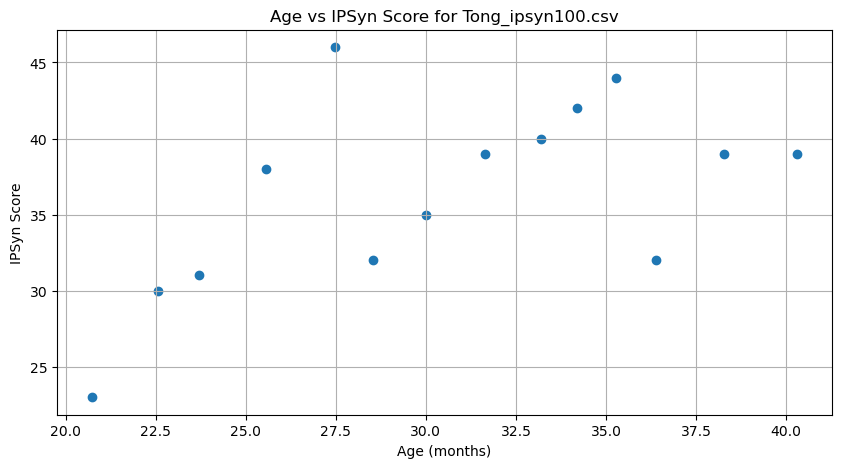

Spearman's rho for Tong_ipsyn100.csv: 0.5503

Chosen Transcripts for Tong_ipsyn100.csv: 
 ['010822.cha', '011017.cha', '011121.cha', '020117.cha', '020314.cha', '020416.cha', '020530.cha', '020719.cha', '020906.cha', '021006.cha', '021108.cha', '030012.cha', '030208.cha', '030409.cha'] 

IPSyn Scores for Tong_ipsyn100.csv: 
 [23.0, 30.0, 31.0, 38.0, 46.0, 32.0, 35.0, 39.0, 40.0, 42.0, 44.0, 32.0, 39.0, 39.0] 

Ages for Tong_ipsyn100.csv: 
 [20.733333333333334, 22.566666666666666, 23.7, 25.566666666666666, 27.46666666666667, 28.53333333333333, 30.0, 31.633333333333333, 33.2, 34.2, 35.266666666666666, 36.4, 38.266666666666666, 40.3] 

Time Steps for Tong_ipsyn100.csv: 
 [1.8333333333333321, 1.1333333333333329, 1.8666666666666671, 1.9000000000000021, 1.0666666666666629, 1.4666666666666686, 1.6333333333333329, 1.56666666666667, 1.0, 1.0666666666666629, 1.1333333333333329, 1.8666666666666671, 2.0333333333333314] 



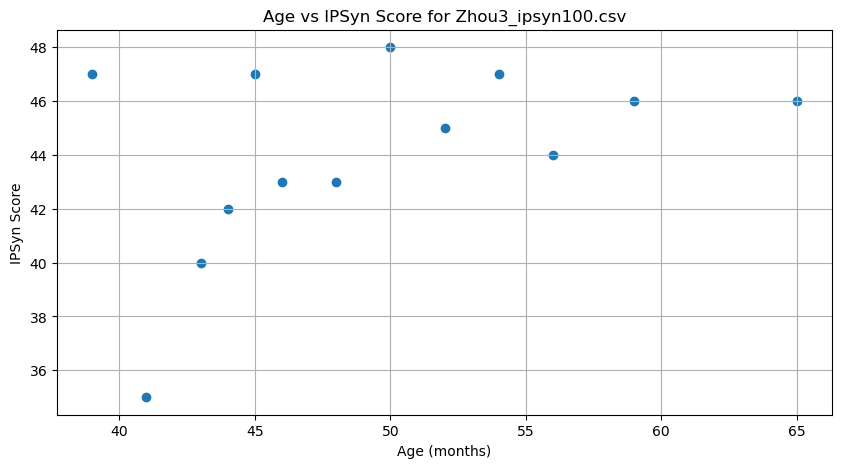

Spearman's rho for Zhou3_ipsyn100.csv: 0.3490

Chosen Transcripts for Zhou3_ipsyn100.csv: 
 ['000108.cha', '000326.cha', '000506.cha', '000610.cha', '000702.cha', '000822.cha', '001005.cha', '001209.cha', '010218.cha', '010421.cha', '010630.cha', '010908.cha', '020323.cha'] 

IPSyn Scores for Zhou3_ipsyn100.csv: 
 [47.0, 35.0, 40.0, 42.0, 47.0, 43.0, 43.0, 48.0, 45.0, 47.0, 44.0, 46.0, 46.0] 

Ages for Zhou3_ipsyn100.csv: 
 [39.0, 41.0, 43.0, 44.0, 45.0, 46.0, 48.0, 50.0, 52.0, 54.0, 56.0, 59.0, 65.0] 

Time Steps for Zhou3_ipsyn100.csv: 
 [2.0, 2.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 3.0, 6.0] 



In [6]:
age_ipsyn_plots(ipsyn_files_100, spearman_rhos_100, age_files)

## Spearman's ρ

In [7]:
spearman_rhos_50

[['Kang_ipsyn50.csv', 0.7999999999999999],
 ['Laohu_ipsyn50.csv', nan],
 ['Peng_ipsyn50.csv', 0.7181848464596079],
 ['Zhong_ipsyn50.csv', 0.9999999999999999],
 ['Cheng_ipsyn50.csv', -0.12591552502863257],
 ['Chou_ipsyn50.csv', 0.6184543950688332],
 ['Chw_ipsyn50.csv', 0.07142857142857144],
 ['Jc_ipsyn50.csv', 0.6747556204512456],
 ['Pan_ipsyn50.csv', 0.6752813502243227],
 ['Wang_ipsyn50.csv', 0.36044428129751194],
 ['Wu_ipsyn50.csv', 0.7228114669971789],
 ['Wuys_ipsyn50.csv', 0.42334475220649564],
 ['Xu_ipsyn50.csv', 0.9315165605535353],
 ['Yang_ipsyn50.csv', 0.6423706870852693],
 ['Tong_ipsyn50.csv', 0.6846496595269468],
 ['Zhou3_ipsyn50.csv', 0.4851184199322681]]

In [8]:
spearman_rhos_100

[['Kang_ipsyn100.csv', -0.39999999999999997],
 ['Laohu_ipsyn100.csv', 0.9999999999999999],
 ['Peng_ipsyn100.csv', 0.9999999999999999],
 ['Zhong_ipsyn100.csv', 0.9999999999999999],
 ['Cheng_ipsyn100.csv', 0.04576766887262615],
 ['Chou_ipsyn100.csv', 0.8312508361216019],
 ['Chw_ipsyn100.csv', -0.1197626261913259],
 ['Jc_ipsyn100.csv', 0.8262121570160877],
 ['Pan_ipsyn100.csv', -0.1563263498701806],
 ['Wang_ipsyn100.csv', -0.2610409621723334],
 ['Wu_ipsyn100.csv', 0.3292744139923163],
 ['Wuys_ipsyn100.csv', 0.3938927711338647],
 ['Xu_ipsyn100.csv', 0.9166666666666666],
 ['Yang_ipsyn100.csv', 0.316227766016838],
 ['Tong_ipsyn100.csv', 0.5502846416293905],
 ['Zhou3_ipsyn100.csv', 0.34904252360306653]]